In [1]:
import numpy as np
import os
import tensorflow as tf
import pathlib
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
from keras.layers import Dropout, Dense, Flatten, LSTM, TimeDistributed
from keras import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.xception import Xception

print(tf.__version__)

2.3.1


In [2]:
#Use all 6 runs's data
run1_str= 'rob501_fall_2020_final_project_submission/project_template/input/run1_base_hr'
run2_str= 'rob501_fall_2020_final_project_submission/project_template/input/run2_base_hr'
run3_str= 'rob501_fall_2020_final_project_submission/project_template/input/run3_base_hr'
run4_str= 'rob501_fall_2020_final_project_submission/project_template/input/run4_base_hr'
run5_str= 'rob501_fall_2020_final_project_submission/project_template/input/run5_base_hr'
run6_str= 'rob501_fall_2020_final_project_submission/project_template/input/run6_base_hr'
img5_str= 'omni_image5'  #only use image from the front bottom color camera


In [3]:
#Use opencv to pre-process image
def process_image(directory_name):
    img_list= []
    for filename in os.listdir(r'./'+directory_name):
        img= cv2.imread(directory_name+'/'+filename)
        img_crop = img[280:,52:752] #crop top half, and left&right side of the image
        img_resize= cv2.resize(img_crop, (300,200)) #horizontally shrink 50%
        img_norm = np.zeros((300,200))
        img_norm = cv2.normalize(img_resize,img_norm, 0,255,cv2.NORM_MINMAX)
        img_list.append(img_norm)
    return img_list

In [4]:
#load and pre-process image from the dataset
def load_image (directory_name):
    path = os.path.join(directory_name,img5_str)
    train_image = np.asarray(process_image(path))
    if directory_name == 'rob501_fall_2020_final_project_submission/project_template/input/run1_base_hr':
        train_image= train_image[14:]
    print('Shape of training images of ', directory_name,' are : ' ,train_image.shape)
    return train_image

In [5]:
train_1= load_image(run1_str)
train_2= load_image(run2_str)
train_3= load_image(run3_str)
train_4= load_image(run4_str)
train_5= load_image(run5_str)
train_6= load_image(run6_str)

Shape of training images of  rob501_fall_2020_final_project_submission/project_template/input/run1_base_hr  are :  (2300, 200, 300, 3)
Shape of training images of  rob501_fall_2020_final_project_submission/project_template/input/run2_base_hr  are :  (2158, 200, 300, 3)
Shape of training images of  rob501_fall_2020_final_project_submission/project_template/input/run3_base_hr  are :  (1621, 200, 300, 3)
Shape of training images of  rob501_fall_2020_final_project_submission/project_template/input/run4_base_hr  are :  (2011, 200, 300, 3)
Shape of training images of  rob501_fall_2020_final_project_submission/project_template/input/run5_base_hr  are :  (3054, 200, 300, 3)
Shape of training images of  rob501_fall_2020_final_project_submission/project_template/input/run6_base_hr  are :  (3113, 200, 300, 3)


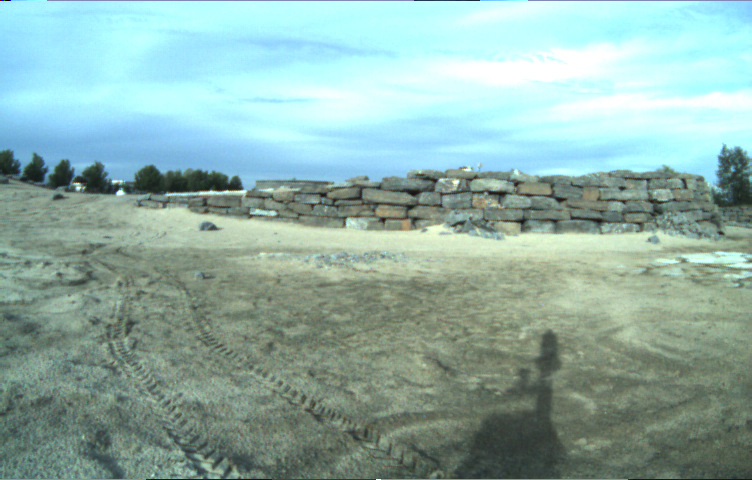

In [8]:
#A sample of raw image before any processing
import PIL
import PIL.Image
path_str= os.path.join(run3_str,img5_str)
data_dir= pathlib.Path(path_str)
images=list(data_dir.glob('**/*.png'))
PIL.Image.open(str(images[1181])) #52th image in Run3, wheel track 

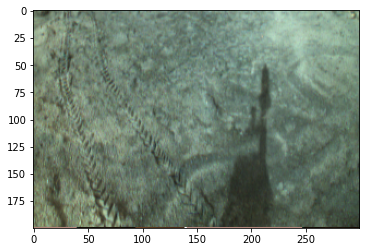

In [9]:
#A sample of the same terrain image after processing
from matplotlib.pyplot import imshow
%matplotlib inline
imshow(train_3[1181]) 

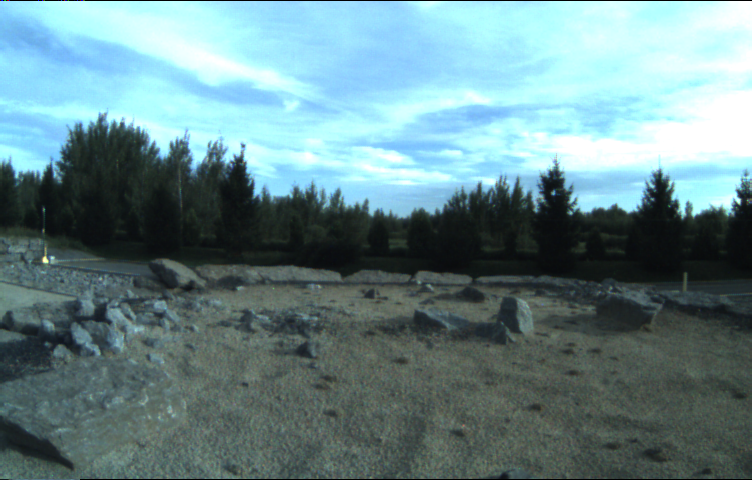

In [10]:
#Another sample of raw image before any processing
path_str= os.path.join(run3_str,img5_str)
data_dir= pathlib.Path(path_str)
images=list(data_dir.glob('**/*.png'))
PIL.Image.open(str(images[538])) #in Run2

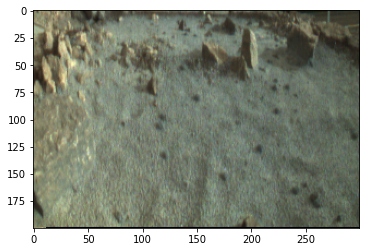

In [11]:
#A sample of the same terrain image after processing
from matplotlib.pyplot import imshow
%matplotlib inline
imshow(train_3[538]) #1589th image in Run2

In [13]:
#function for loading power data from energy.txt
def load_power(input_dir,start,end):
    energy_str= 'energy.txt'
    f=open(os.path.join(input_dir,energy_str) ,"r")
    lines=f.readlines()
    p_l=[] #left wheel power
    p_r=[] #righ wheel power
    for x in lines[1:]:
        str_l= x.split(',')[5]
        flt_l=float(str_l) #conver string to float
        p_l.append(flt_l)
        str_r= x.split(',')[6]
        flt_r= float(str_r) #conver string to float
        p_r.append(flt_r)

    total_power=np.add(p_l,p_r)
    DELETE_STEP=9
    # the rgb images are about 1/9 less than the energy data
    power_delete= np.delete(total_power,np.arange(0, total_power.size,DELETE_STEP)) 
    #cut off several starting and ending power data, to match the sample amount of color images
    #Also starting and ending power are usually very small(close to zero) when rover are paused.
    power_data = np.expand_dims(power_delete, axis=1)[start:end]
    print('Shape of power data of ', input_dir,' are : ' ,power_data.shape)
    return power_data

In [14]:
power_1 = load_power(run1_str,30,2330)
power_2 = load_power(run2_str,12,2170)
power_3 = load_power(run3_str,6,1627)
power_4 = load_power(run4_str,10,2021)
power_5 = load_power(run5_str,15,3069)
power_6 = load_power(run6_str,17,3130)

Shape of power data of  rob501_fall_2020_final_project_submission/project_template/input/run1_base_hr  are :  (2300, 1)
Shape of power data of  rob501_fall_2020_final_project_submission/project_template/input/run2_base_hr  are :  (2158, 1)
Shape of power data of  rob501_fall_2020_final_project_submission/project_template/input/run3_base_hr  are :  (1621, 1)
Shape of power data of  rob501_fall_2020_final_project_submission/project_template/input/run4_base_hr  are :  (2011, 1)
Shape of power data of  rob501_fall_2020_final_project_submission/project_template/input/run5_base_hr  are :  (3054, 1)
Shape of power data of  rob501_fall_2020_final_project_submission/project_template/input/run6_base_hr  are :  (3113, 1)


In [15]:
'''
Use Runs 1,3,4,5,6 as training data, 12099 samples
Use Run2 as test data, 2158 samples
'''
train_4d= np.concatenate((train_1,train_3,train_4,train_5,train_6))
print(train_4d.shape) #4d array
power_2d=np.concatenate((power_1,power_3,power_4,power_5,power_6))
print(power_2d.shape)

(12099, 200, 300, 3)
(12099, 1)


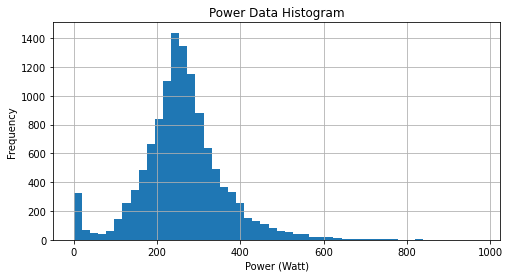

In [38]:
#Power histogram
plt.hist(power_2d, bins = 50)
plt.title('Power Data Histogram')
plt.ylabel('Frequency')
plt.xlabel('Power (Watt)')
plt.rcParams["figure.figsize"] = (8,4)
plt.grid(axis='both')
plt.show()

In [45]:
#average power for holdout testset
power_mean= np.mean(power_2)
print(power_mean)
target_mae= 0.25 * power_mean
print('The target performance of MAE is : ', target_mae)

257.40035393883227
The target performance of MAE is :  64.35008848470807


In [16]:
'''
Deep learning model, used transfer learning from Xception model,
An upgrade version of Inception V3 model
Published by Franc¸ois Chollet in 2017,trained on ImageNet
Last 7 layers of Xception model can be trained

Followed by 2 LSTM layers to capture sequence relations
Followed by TimeDistributed wrapped Dense layers, 
to chronically load a batch of 8 output from LSTM layers,
and corelate to a batch of 8 output power data.
''' 
#Check if CUDNN is loaded properly
tf.config.list_physical_devices('GPU')

# create a Sequential model
model = Sequential()

# load Xception model for transferlearning
xception = Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(200, 300, 3)
)
# Train the last 5 layers of Xception model
for layer in xception.layers[:-5]:
    layer.trainable = False
    
model.add(xception)

#LSTM Layers
model.add(tf.keras.layers.Reshape((70, 2048))) #reshape from xception to LSTM
model.add(LSTM(256, return_sequences = True, input_shape =(70,2048)))
model.add(LSTM(64, return_sequences = True))

#Time Distributed Layers to corelate a batch of 8
model.add(TimeDistributed(Dense(64),input_shape=(8,70,64)))
model.add(TimeDistributed(Dense(32)))
model.add(TimeDistributed(Flatten()))
model.add(TimeDistributed(Dropout(.5)))
model.add((TimeDistributed(Dense(1))))

opt = Adam(learning_rate=1e-4)
model.compile(optimizer =opt, loss='mse', metrics = ['mae'])

#Training settings:
BATCH_SIZE = 32
EPOCHS = 50
VERBOSE = 1
#call back functions
earlystopping= EarlyStopping(monitor='val_mae', patience=3, mode='min')
savebest = ModelCheckpoint('bestXceptionModel', monitor = 'val_mae',
                           save_best_only=True,save_weights_only=False, mode='min')

print(model.summary())
history = model.fit(train_4d, power_2d, batch_size=BATCH_SIZE, 
                    epochs=EPOCHS,verbose=VERBOSE, validation_split=0.2, 
                    callbacks=[earlystopping,savebest])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 10, 2048)       20861480  
_________________________________________________________________
reshape (Reshape)            (None, 70, 2048)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 70, 256)           2360320   
_________________________________________________________________
lstm_1 (LSTM)                (None, 70, 64)            82176     
_________________________________________________________________
time_distributed (TimeDistri (None, 70, 64)            4160      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 70, 32)            2080      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 70, 32)            0

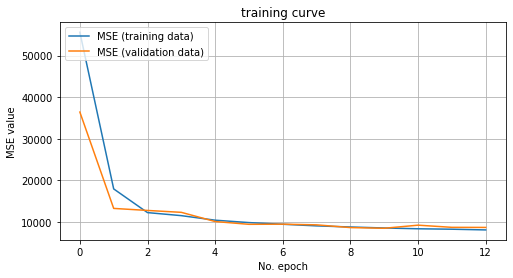

In [34]:
# Plot MSE training history
plt.plot(history.history['loss'], label='MSE (training data)')
plt.plot(history.history['val_loss'], label='MSE (validation data)')
plt.title('training curve')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.rcParams["figure.figsize"] = (8,4)
plt.grid(axis='both')
plt.show()

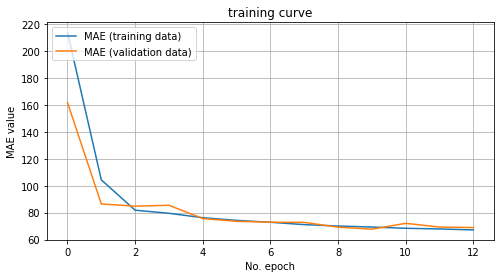

In [35]:
#Plot MAE training history
plt.plot(history.history['mae'], label='MAE (training data)')
plt.plot(history.history['val_mae'], label='MAE (validation data)')
plt.title('training curve')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.rcParams["figure.figsize"] = (8,4)
plt.grid(axis='both')

In [27]:
#load best performaing model during training
saved_best_model = keras.models.load_model('bestXceptionModel')
print(saved_best_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 10, 2048)       20861480  
_________________________________________________________________
reshape (Reshape)            (None, 70, 2048)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 70, 256)           2360320   
_________________________________________________________________
lstm_1 (LSTM)                (None, 70, 64)            82176     
_________________________________________________________________
time_distributed (TimeDistri (None, 70, 64)            4160      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 70, 32)            2080      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 70, 32)            0

In [29]:
#Performance evaluation on Test set : Run2
predictions = saved_best_model.predict(train_2, batch_size=32)[:,0,0]
predictions = np.squeeze(predictions)
print(predictions.shape)
mae = np.mean(np.absolute(power_2 - predictions))
print('The mean absolute error on Testset Run2 is : ', mae)

(2158,)
The mean absolute error on Testset Run2 is :  63.27741611679313


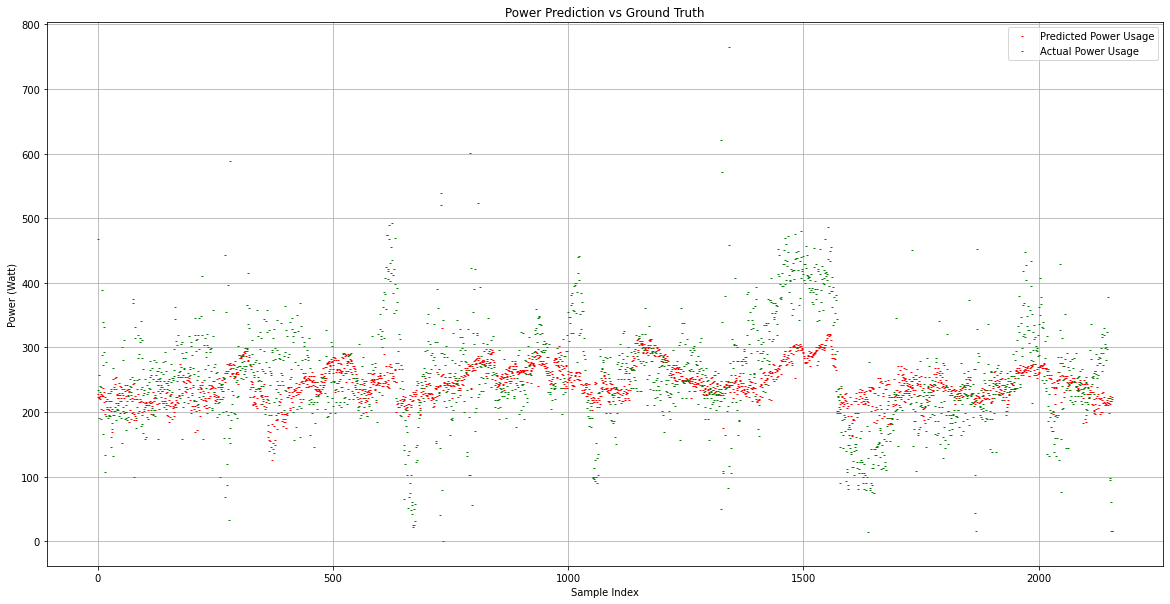

In [48]:
# plot predicted power draw vs actual power draw
plt.figure(figsize=(20, 10))
plt.plot(predictions, 'r_', markersize=2, label='Predicted Power Usage')
plt.plot(power_2, 'g_', markersize=2, label='Actual Power Usage')
plt.title('Power Prediction vs Ground Truth')
plt.ylabel('Power (Watt)')
plt.xlabel('Sample Index')
plt.legend()
plt.grid()

The Model achieves a MAE of 63.28 on unseen testset data Run2, which reached the objective of 64.35 MAE.
In context, the averagetotal power of the rover is 316.8 W over the span of 6 runs. 
The performance of 63.28 MAE is equivalent to 24.5% deviation from ground truth power consumption.